# Team 1 CS 105 Final Project Data Processing and Analysis

Now, we will start processing the reviews and build the vocabulary for our bag-of-worlds model.

In [1]:
import os
#import shutil
import numpy as np

import codecs
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

neg_dir = 'Project Datasets/neg'
pos_dir = 'Project Datasets/pos'

indices = []
train = []

for file in os.listdir(os.path.join(os.getcwd(), neg_dir)):
    f = os.path.join(os.getcwd(), neg_dir, file)
    text_input = codecs.open(f, 'r', encoding='utf-8', errors='ignore')
    text = text_input.read()
    train.append(text)
    indices.append(file[:-4])
    text_input.close()

for file in os.listdir(os.path.join(os.getcwd(), pos_dir)):
    f = os.path.join(os.getcwd(), pos_dir, file)
    text_input = codecs.open(f, 'r', encoding='utf-8', errors='ignore')
    text = text_input.read()
    train.append(text)
    indices.append(file[:-4])
    text_input.close()

# Tf-IDF Vectorizor
# Don't indlude stop words in vocabulary
# Only include tokens that appear in at least 10 documents
# Remove strictly numeric tokens
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words='english', min_df=10,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

tfidf_word_matrix = tfidfvectorizer.fit_transform(train)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(data = tfidf_word_matrix.toarray(), index = indices, columns = tfidf_tokens)

# Labelling data
df_tfidf['LABEL'] = 'Negative'
df_tfidf.iloc[2500:,-1] = 'Positive'

df_tfidf

,13th,1930s,1940s,1950s,1960s,1970s,1980s,1990s,19th,1st,...,youngest,youth,youthful,youtube,z,zero,zombie,zombies,zone,LABEL
10003_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
10007_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
10009_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
10010_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
10012_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Positive
9976_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Positive
9979_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Positive
9988_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Positive


Now, let's create our train and test sets. We will first look at how Gaussian Naive Bayes performs.

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Creating Train and Test sets
X = np.array(df_tfidf.drop(['LABEL'], axis=1))
Y = np.array(df_tfidf['LABEL'])

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=123)

naive = GaussianNB()
naive.fit(X_train, Y_train)

Y_pred_NB = naive.predict(X_test)
print('Accuracy using Gaussian Naive Bayes =', accuracy_score(Y_test, Y_pred_NB))

Accuracy using Gaussian Naive Bayes = 0.744


In [3]:
# Print Classification Report
print(classification_report(Y_test, Y_pred_NB))

              precision    recall  f1-score   support

    Negative       0.74      0.75      0.75       253
    Positive       0.74      0.73      0.74       247

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500



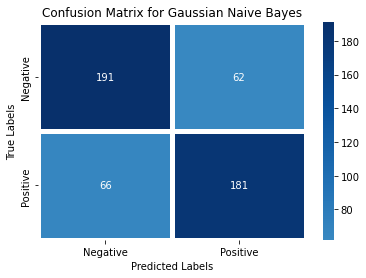

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion matrix heatmap
cf = confusion_matrix(Y_test, Y_pred_NB)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for Gaussian Naive Bayes')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

As you can see from the confusion matrix, from our test set, we correctly classified 183 negative reviews correctly and 178 positive reviews correctly. We incorrectly classified 70 negative reviews as positive and 69 positive reviews as negative. Let's now test how a SVM model will perform using the same train and test sets.

In [5]:
from sklearn.svm import SVC

SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, Y_train)

Y_pred_SVM = SVM.predict(X_test)
print('Accuracy using SVM =', accuracy_score(Y_test, Y_pred_SVM))

Accuracy using SVM = 0.856


In [6]:
# Print Classification Report
print(classification_report(Y_test, Y_pred_SVM))

              precision    recall  f1-score   support

    Negative       0.88      0.83      0.85       253
    Positive       0.83      0.89      0.86       247

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



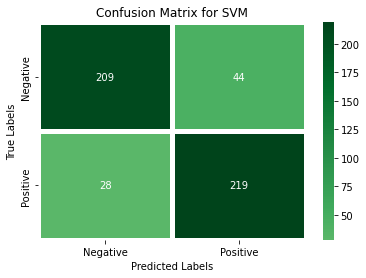

In [7]:
# Plot Confusion matrix heatmap
cf = confusion_matrix(Y_test, Y_pred_SVM)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Greens", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for SVM')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

As you can see from the confusion matrix, from our test set, we correctly classified 205 negative reviews correctly and 214 positive reviews correctly. We incorrectly classified 48 negative reviews as positive and 33 positive reviews as negative. Our SVM model performs slightly better than Gaussian Naive Bayes, so we will save SVM as our final model.

In [8]:
import pickle

filename = 'review_classifier.pkl'
f = open(filename, 'wb')
pickle.dump(SVM, f)
f.close()